In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

#### compute confidence for different types of classification in each task

In [6]:
n_tasks = 4
n_classtypes = 5
n_trialgroups = 2;

trial_group_names = ['all main','hard main']

conf = np.zeros((n_subjects, n_rois, n_tasks, n_classtypes, n_trialgroups))

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T.round(2)
        
        is_main_grid = l['is_main_grid']==1
        
        dist = np.array(l['dist_from_center']).round(2)
        
        hard = dist==1.13
        
        quad_actual = np.array(l['quadrant']).astype(int)
        
        correct = np.array(l['subject_correct'])
        
        # inds = is_main_grid
        inds = is_main_grid & correct
        
        for tgi, inds in enumerate([is_main_grid, \
                                    is_main_grid & hard]):


            for ri in range(n_rois):

                prob = dec_withintask['probs_all'][si][ri][ti]

                for cti in range(n_classtypes):

                    # print(cti)
                    if cti<3:

                        tt = cti+1

                        g1 = grid_utils.get_categ(grid_pts, tt)==1
                        p_categ1 = np.sum(prob[:,g1], axis=1)
                        g2 = grid_utils.get_categ(grid_pts, tt)==2
                        p_categ2 = np.sum(prob[:,g2], axis=1)

                        categ_actual = grid_utils.get_categ(pt_labs,tt)

                        # signed confidence will be: p(correct) - p(incorrect)
                        signedconf = np.zeros_like(p_categ1)
                        signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                        signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]


                    elif cti==3:

                        quadgroups = [grid_utils.get_quadrant(grid_pts)==qq for qq in [1,2,3,4]]
                        quadprobs = np.array([np.sum(prob[:,q], axis=1) for q in quadgroups]).T

                        # signed confidence will be: p(correct) - p(incorrect)
                        signedconf = np.zeros_like(quadprobs[:,0])
                        signedconf[quad_actual==1] = quadprobs[quad_actual==1,0] - \
                                                    np.mean(quadprobs[quad_actual==1][:,[1,2,3]], axis=1)
                        signedconf[quad_actual==2] = quadprobs[quad_actual==2,1] - \
                                                    np.mean(quadprobs[quad_actual==2][:,[0,2,3]], axis=1)
                        signedconf[quad_actual==3] = quadprobs[quad_actual==3,2] - \
                                                    np.mean(quadprobs[quad_actual==3][:,[0,1,3]], axis=1)
                        signedconf[quad_actual==4] = quadprobs[quad_actual==4,3] - \
                                                    np.mean(quadprobs[quad_actual==4][:,[0,1,2]], axis=1)
                
                    elif cti==4:
                        
                        signedconf = np.zeros_like(prob[:,0])
                        
                        n_pts = prob.shape[1]
                        
                        for xx in np.arange(n_pts):
                            
                            ptinds = np.all(pt_labs==grid_pts[xx,:].round(2), axis=1)
                            signedconf[ptinds] = prob[ptinds,xx] - np.mean(prob[ptinds,:][:,np.arange(n_pts)!=xx], axis=1)

                    conf[si,ri,ti,cti,tgi] = np.mean(signedconf[inds])
                    
                

Text(0.5, 0.98, 'hard main')

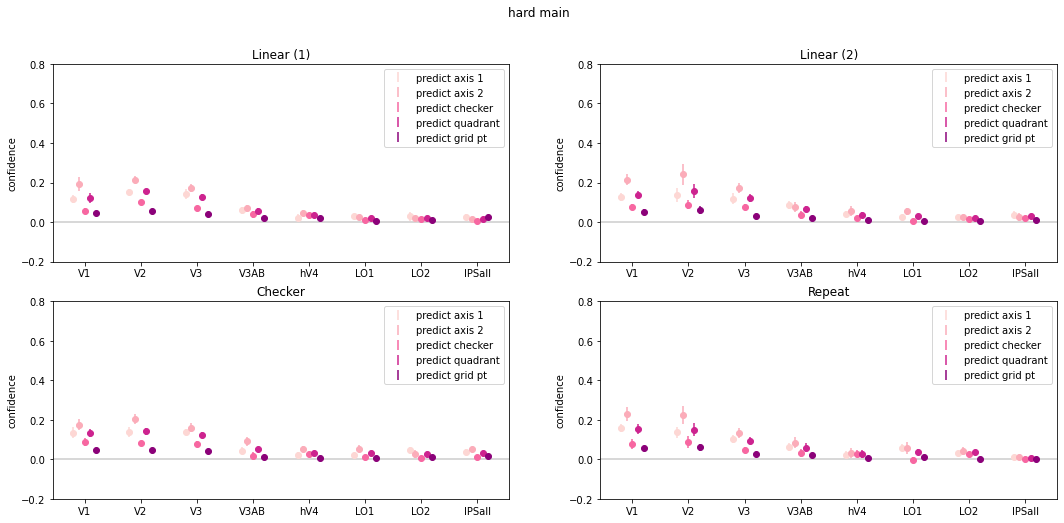

In [7]:
tgi = 1;
tgname = trial_group_names[tgi]

plt.figure(figsize=(18,8))

cvals = conf

class_type_colors = cm.RdPu(np.linspace(0,1,7))[1:6,:]
class_type_names = ['predict axis 1','predict axis 2','predict checker','predict quadrant','predict grid pt']

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, 5)

for ti in ti_plot:
    
    plt.subplot(2,2,ti+1)
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for cti in [0,1,2,3,4]:

        x_ticks = np.arange(n_rois) + x_jitter[cti]

        vals = cvals[:,:,ti,cti,tgi]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

        plt.plot(x_ticks, meanvals, 'o', color=class_type_colors[cti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=class_type_colors[cti], linestyle='none')
        lh.append(h)

    plt.ylim([-0.20, 0.80])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')

    plt.legend(lh,class_type_names)

    plt.title('%s'%(task_names[ti]))
    
plt.suptitle('%s'%trial_group_names[tgi])


Text(0.5, 0.98, 'all main')

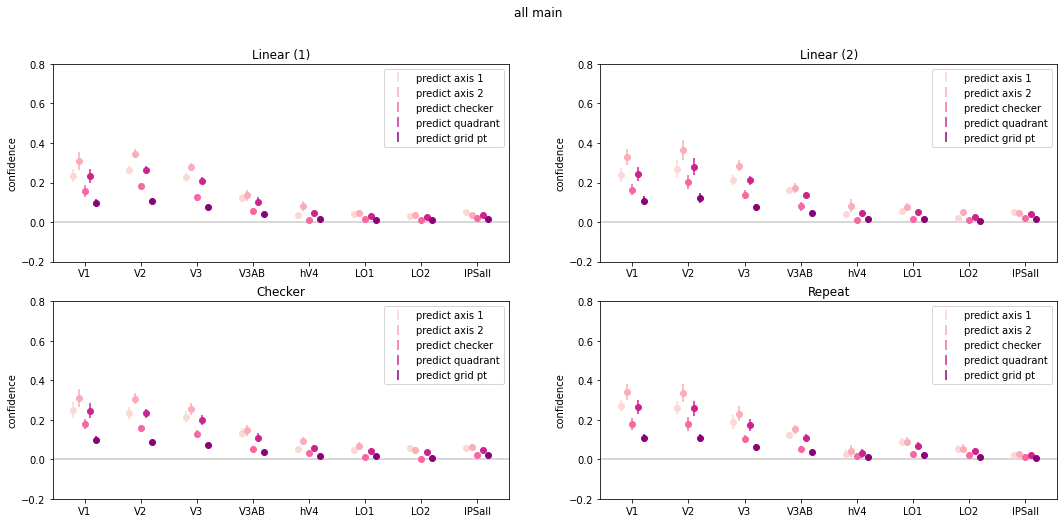

In [8]:
tgi = 0
tgname = trial_group_names[tgi]

plt.figure(figsize=(18,8))

cvals = conf

class_type_colors = cm.RdPu(np.linspace(0,1,7))[1:6,:]
class_type_names = ['predict axis 1','predict axis 2','predict checker','predict quadrant','predict grid pt']

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, 5)

for ti in ti_plot:
    
    plt.subplot(2,2,ti+1)
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for cti in [0,1,2,3,4]:

        x_ticks = np.arange(n_rois) + x_jitter[cti]

        vals = cvals[:,:,ti,cti,tgi]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

        plt.plot(x_ticks, meanvals, 'o', color=class_type_colors[cti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=class_type_colors[cti], linestyle='none')
        lh.append(h)

    plt.ylim([-0.20, 0.80])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')

    plt.legend(lh,class_type_names)

    plt.title('%s'%(task_names[ti]))
    
plt.suptitle('%s'%trial_group_names[tgi])


Text(0.5, 0.98, 'all main')

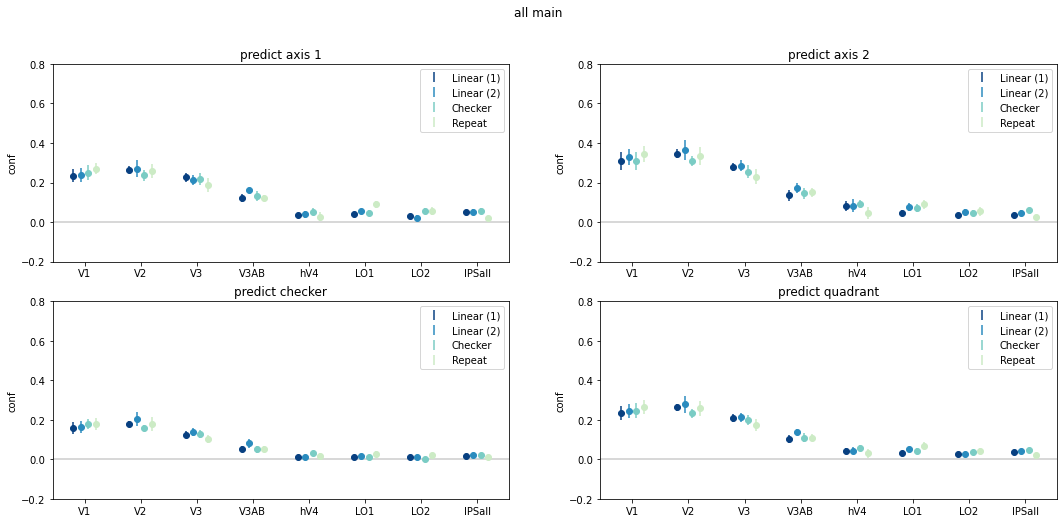

In [9]:
tgi = 0;

trial_group_names = ['all main','hard main']
tgname = trial_group_names[tgi]

ti_plot =[0,1,2,3]
# ti_plot = [2,3]
x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

class_type_colors = cm.RdPu(np.linspace(0,1,6))[1:5,:]
class_type_names = ['predict axis 1','predict axis 2','predict checker','predict quadrant', 'predict grid pt']

plt.figure(figsize=(18,8))

for cti in [0,1,2,3]:
   
    plt.subplot(2,2,cti+1)
    
    ctname = class_type_names[cti]
    
    vals = conf[:,:,:,cti,tgi]

    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

    
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for tii, ti in enumerate(ti_plot):

        x_ticks = np.arange(n_rois) + x_jitter[tii]

        plt.plot(x_ticks, meanvals[:,ti], 'o',color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals[:,ti], \
                     semvals[:,ti], \
                     xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    # for ri in range(n_rois):

    #     meanvals = np.mean(vals[:,ri,ti_plot], axis=0)
    #     plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6])

        # plt.plot(ri+x_jitter, vals[:,ri,ti_plot].T, color=[0.8, 0.8, 0.8], zorder=-10)


    plt.ylim([-0.2,0.80])
    # plt.ylim([-0.001, 0.001])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('conf')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.title('%s'%(ctname))
    
plt.suptitle(tgname)


Text(0.5, 0.98, 'hard main')

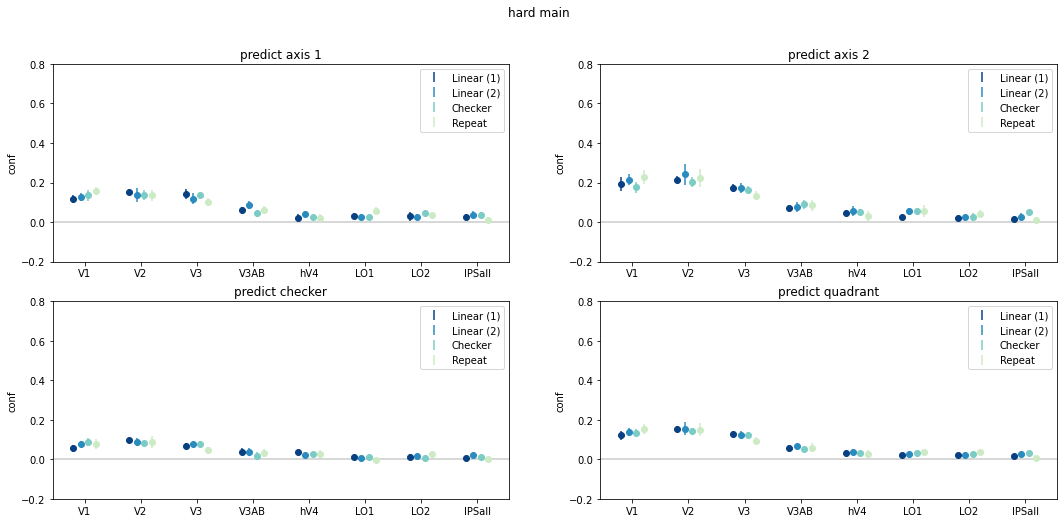

In [10]:
tgi = 1;

trial_group_names = ['all main','hard main']
tgname = trial_group_names[tgi]

ti_plot =[0,1,2,3]
# ti_plot = [2,3]
x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

class_type_colors = cm.RdPu(np.linspace(0,1,6))[1:5,:]
class_type_names = ['predict axis 1','predict axis 2','predict checker','predict quadrant', 'predict grid pt']

plt.figure(figsize=(18,8))

for cti in [0,1,2,3]:
   
    plt.subplot(2,2,cti+1)
    
    ctname = class_type_names[cti]
    
    vals = conf[:,:,:,cti,tgi]

    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

    
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for tii, ti in enumerate(ti_plot):

        x_ticks = np.arange(n_rois) + x_jitter[tii]

        plt.plot(x_ticks, meanvals[:,ti], 'o',color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals[:,ti], \
                     semvals[:,ti], \
                     xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    # for ri in range(n_rois):

    #     meanvals = np.mean(vals[:,ri,ti_plot], axis=0)
    #     plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6])

        # plt.plot(ri+x_jitter, vals[:,ri,ti_plot].T, color=[0.8, 0.8, 0.8], zorder=-10)


    plt.ylim([-0.2,0.80])
    # plt.ylim([-0.001, 0.001])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('conf')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.title('%s'%(ctname))
    
plt.suptitle(tgname)


Text(0.5, 0.98, 'hard main')

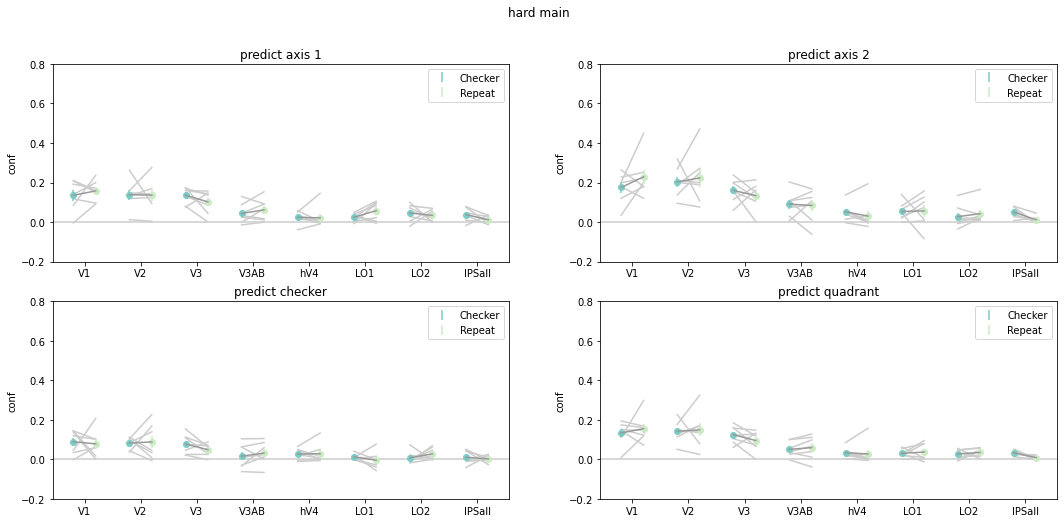

In [11]:
tgi = 1;

trial_group_names = ['all main','hard main']
tgname = trial_group_names[tgi]

# ti_plot =[0,1,2,3]
ti_plot = [2,3]
x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

class_type_colors = cm.RdPu(np.linspace(0,1,6))[1:5,:]
class_type_names = ['predict axis 1','predict axis 2','predict checker','predict quadrant', 'predict grid pt']

plt.figure(figsize=(18,8))

for cti in [0,1,2,3]:
   
    plt.subplot(2,2,cti+1)
    
    ctname = class_type_names[cti]
    
    vals = conf[:,:,:,cti,tgi]

    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

    
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for tii, ti in enumerate(ti_plot):

        x_ticks = np.arange(n_rois) + x_jitter[tii]

        plt.plot(x_ticks, meanvals[:,ti], 'o',color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals[:,ti], \
                     semvals[:,ti], \
                     xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    for ri in range(n_rois):

        meanvals = np.mean(vals[:,ri,ti_plot], axis=0)
        plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6])

        plt.plot(ri+x_jitter, vals[:,ri,ti_plot].T, color=[0.8, 0.8, 0.8], zorder=-10)


    plt.ylim([-0.2,0.80])
    # plt.ylim([-0.001, 0.001])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('conf')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.title('%s'%(ctname))
    
plt.suptitle(tgname)


Text(0.5, 0.98, 'all main')

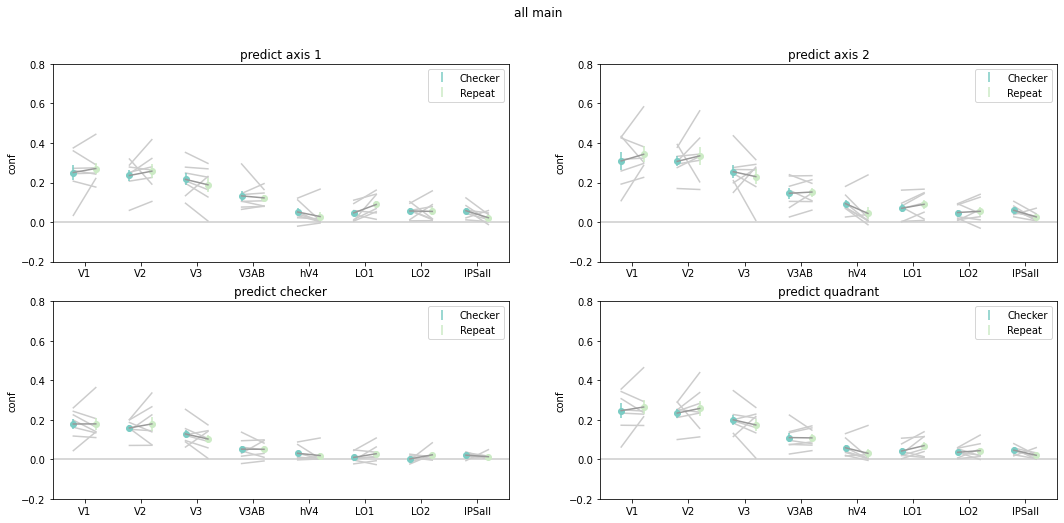

In [12]:
tgi = 0;

trial_group_names = ['all main','hard main']
tgname = trial_group_names[tgi]

# ti_plot =[0,1,2,3]
ti_plot = [2,3]
x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

class_type_colors = cm.RdPu(np.linspace(0,1,6))[1:5,:]
class_type_names = ['predict axis 1','predict axis 2','predict checker','predict quadrant', 'predict grid pt']

plt.figure(figsize=(18,8))

for cti in [0,1,2,3]:
   
    plt.subplot(2,2,cti+1)
    
    ctname = class_type_names[cti]
    
    vals = conf[:,:,:,cti,tgi]

    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

    
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for tii, ti in enumerate(ti_plot):

        x_ticks = np.arange(n_rois) + x_jitter[tii]

        plt.plot(x_ticks, meanvals[:,ti], 'o',color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals[:,ti], \
                     semvals[:,ti], \
                     xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    for ri in range(n_rois):

        meanvals = np.mean(vals[:,ri,ti_plot], axis=0)
        plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6])

        plt.plot(ri+x_jitter, vals[:,ri,ti_plot].T, color=[0.8, 0.8, 0.8], zorder=-10)


    plt.ylim([-0.2,0.80])
    # plt.ylim([-0.001, 0.001])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('conf')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.title('%s'%(ctname))
    
plt.suptitle(tgname)
